In [1]:
from sumpy.recurrence import _make_sympy_vec, get_reindexed_and_center_origin_on_axis_recurrence

from sumpy.expansion.diff_op import (
    laplacian,
    make_identity_diff_op,
)

import sympy as sp
from sympy import hankel1

import numpy as np
import math

from sympy import count_ops

import matplotlib.pyplot as plt
from matplotlib import cm, ticker

from sympy import cse

In [2]:
w = make_identity_diff_op(2)
helmholtz2d = laplacian(w) + w
laplace2d = laplacian(w)
n = sp.symbols("n")
s = sp.Function("s")
var = _make_sympy_vec("x", 2)
n_init_helm, order_helm, recur_helmholtz = get_reindexed_and_center_origin_on_axis_recurrence(helmholtz2d)
n_init_lap, order_lap, recur_lap = get_reindexed_and_center_origin_on_axis_recurrence(laplace2d)

In [3]:
def compute_derivatives_helmholtz(p):
    var = _make_sympy_vec("x", 2)
    var_t = _make_sympy_vec("t", 2)
    abs_dist = sp.sqrt((var[0]-var_t[0])**2 +
                       (var[1]-var_t[1])**2)
    k = 1
    g_x_y = (1j/4) * hankel1(0, k * abs_dist)
    derivs = [sp.diff(g_x_y,
                      var_t[0], i).subs(var_t[0], 0).subs(var_t[1], 0)
                                               for i in range(p)]
    return derivs
l_max_h = 7
derivs_helmholtz = compute_derivatives_helmholtz(l_max_h)

In [4]:
def compute_derivatives_laplace(p):
    var = _make_sympy_vec("x", 2)
    var_t = _make_sympy_vec("t", 2)
    g_x_y = sp.log(sp.sqrt((var[0]-var_t[0])**2 + (var[1]-var_t[1])**2))
    derivs = [sp.diff(g_x_y,
                      var_t[0], i).subs(var_t[0], 0).subs(var_t[1], 0)
                      for i in range(p)]
    return derivs
l_max_l = 15
derivs_laplace = compute_derivatives_laplace(l_max_l)

In [5]:
from immutabledict import immutabledict
from sumpy.expansion.diff_op import LinearPDESystemOperator
from collections import namedtuple
DerivativeIdentifier = namedtuple("DerivativeIdentifier", ["mi", "vec_idx"])
partial_4x = DerivativeIdentifier((4,0), 0)
partial_4y = DerivativeIdentifier((0,4), 0)
partial_2x2y = DerivativeIdentifier((2,2), 0)
biharmonic_op = {partial_4x: 1, partial_4y: 1, partial_2x2y:2}
list_pde = immutabledict(biharmonic_op)
biharmonic_pde = LinearPDESystemOperator(2, (list_pde,))
n_init_bih, order_bih, recur_bih = get_reindexed_and_center_origin_on_axis_recurrence(biharmonic_pde)
def compute_derivatives_biharmonic(p):
    var = _make_sympy_vec("x", 2)
    var_t = _make_sympy_vec("t", 2)
    abs_dist = sp.sqrt((var[0]-var_t[0])**2 + (var[1]-var_t[1])**2)
    g_x_y = abs_dist**2 * (sp.log(abs_dist))
    derivs = [sp.diff(g_x_y,
                    var_t[0], i).subs(var_t[0], 0).subs(var_t[1], 0)
                                            for i in range(p)]
    return derivs
derivs_bih = compute_derivatives_biharmonic(15)

In [6]:
n_s = 20
s_vec = _make_sympy_vec("s", n_s)
subs_dict_s_vec = dict(zip([s(i) for i in range(n_s)], [s_vec[i] for i in range(n_s)]))

In [7]:
r = sp.symbols("r")

In [8]:
def old_expansion_create(start, stop, derivs):
    return (sum(derivs[i]*r**i/math.factorial(i) for i in range(start, stop)))

In [9]:
def new_expansion_create(start, stop, recur):
    return (sum(recur.subs(n,i)*r**i/math.factorial(i) for i in range(start, stop)))

In [10]:
def get_flops_per_order_lt(l_t_order, derivs, recur, n_init, simplify=True):
    old_exp_flops = []
    new_exp_flops = []
    for i in range(l_t_order):
        if simplify:
            old_exp_flops.append(count_ops(cse((old_expansion_create(0, i+1, derivs)).simplify())))
            new_exp_flops.append(count_ops(cse(((old_expansion_create(0, min(i+1,n_init), derivs) + (new_expansion_create(n_init, i+1, recur)+var[0]*0).subs(subs_dict_s_vec)).simplify()))))
        else:
            old_exp_flops.append(count_ops(cse((old_expansion_create(0, i+1, derivs)))))
            new_exp_flops.append(count_ops(cse(((old_expansion_create(0, min(i+1,n_init), derivs) + (new_expansion_create(n_init, i+1, recur)+var[0]*0).subs(subs_dict_s_vec))))))
    return old_exp_flops, new_exp_flops

In [11]:
old_lap_flops, new_lap_flops = get_flops_per_order_lt(10, derivs_laplace, recur_lap, n_init_lap)

In [12]:
old_helm_flops, new_helm_flops = get_flops_per_order_lt(7, derivs_helmholtz, recur_helmholtz, n_init_helm, simplify=False)

Text(0.5, 0, 'Line-Taylor Order')

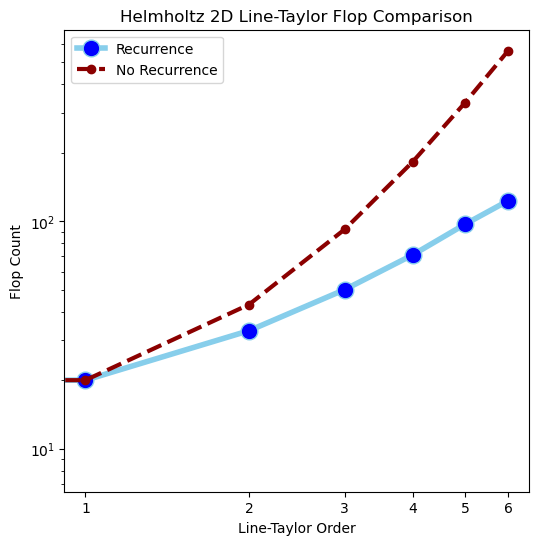

In [ ]:
fig, ax = plt.subplots(figsize = (6, 6))
ax.set_yscale("log")
ax.set_xscale("log")
ax.plot([i for i in range(7)], new_helm_flops, 
    marker='o', # marker type
    markerfacecolor='blue', # color of marker
    markersize=12, # size of marker
    color='skyblue', # color of line
    linewidth=4, # change width of line)
    label='Recurrence'
)
ax.plot([i for i in range(7)], old_helm_flops, 
    marker='o', # no marker
    color='darkred', # color of line
    linewidth=3, # change width of line
    linestyle='dashed', # change type of line
    label="No Recurrence" # label for legend)
)
ax.set_xticks([i+1 for i in range(6)])
ax.set_xticklabels(str(i+1) for i in range(6))
ax.legend()
ax.set_title("Helmholtz 2D Line-Taylor Flop Comparison")
ax.set_ylabel("Flop Count")
ax.set_xlabel("Line-Taylor Order")
fig.savefig("Helmholtz2DCost.svg")

In [14]:
expr = var[0]**2 +sp.sin(var[0]**2)

In [15]:
expr

x0**2 + sin(x0**2)

In [16]:
count_ops(expr)

4

In [17]:
cse(expr)

([(x1, x0**2)], [x1 + sin(x1)])

In [18]:
count_ops(cse(expr))

3